# UFO Sightings
## Motivation
Our dataset is a collection of ufo sightings maintained by the __National UFO Reporting Center__ foundation since 1998, even though the first recorded data going back until 1906. In particular, for every sighting we have data about: the geographical localization, datetime, duration of the sighting, shape of the object and a brief comment of the situation.
We chose this dataset because we find it curious and from some points of view fun to work with, recently (march 2025) in the european skys a [bright blue spiral appeared](https://www.bbc.com/news/articles/c241073v66jo) reopening the debate on the theme. Also we were intrested in working in less clean dataset, as an online form report is, to work more directly with people behaviour and perception of the phenomenon. We were also interested in learing more about natural language processing models, performing an analysis also in the open comment section of the dataset.
The final goal of this report is presenting the situation of ufo sightings to the reader, firstly by a general descritpion of the dataset that we analyzied, then a focus part on a sentiment analysis of the reporters and in conclusion a comparison between debunkers and ufo believers.
## Basic statistics
As previously highlighted, since the dataset is coming from an online form, with data inserted directly by users, we weren't surprised in finding some incongruences and some unsanitized data. As a first activity, we fixed some writing errors in the dataset, such as random characters in numeric fields (ex. a value of latitude _33q.200088_ or a value of duration _8'_). In addition we found the following incongruences:
- The colums duration (seconds) and (hours/min) sometimes contain different values. We decided to analyze only data in seconds, since they are more standardized and comparable between themself, whereas hours/min are in some cases more vague (ex. 1/2 hours) and unstandardized (ex. _5 minutes_ vs _5 min. 7 sec_ vs _several minutes_ etc.).
- Some row contain a value of date posted anterior to the sighting datetime, we interpreted this as an error in the report instead of a prediction of the future, so in these rows we switch the two values.
Furthermore, we group the shape described by the reporters in a more precise set of cathegories, for a better classification.
Eventually, we found a lot of missing and inconsistent values in city, state and country fields, so we decided to ignore these values and to use only latitude and longitude for geolocalization.

In [69]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

dataset = pd.read_csv('ufo_sightings_scrubbed.csv', dtype={
    'datetime': str,
    'city': str,
    'state': str,
    'country': str,
    'shape': str,
    'duration (seconds)': float,
    'duration (hours/min)': str,
    'comments': str,
    'date posted': str,
    'latitude': float,
    'longitude': float
})
dataset['datetime'] = pd.to_datetime(dataset['datetime'])
dataset['date posted'] = pd.to_datetime(dataset['date posted'])
# Drop unnecessary columns
dataset.drop(columns=['city', 'state', 'country', 'duration (hours/min)'], inplace=True)
# Rename colum duration (seconds) to duration
dataset.rename(columns={'duration (seconds)': 'duration'}, inplace=True)

# Swap datetime and date posted if datetime is greater than date posted
mask = dataset['datetime'].dt.date > dataset['date posted'].dt.date
dataset.loc[mask, ['datetime', 'date posted']] = dataset.loc[mask, ['date posted', 'datetime']].values

# Shape mapping
shape_mapping = {
    'cylinder': 'cylinder',
    'light': 'flash',
    'circle': 'disk',
    'sphere': 'sphere',
    'disk': 'disk',
    'fireball': 'fireball',
    'unknown': 'unknown',
    'oval': 'oval',
    'other': 'other',
    'cigar': 'cylinder',
    'rectangle': 'rectangle',
    'chevron': 'chevron',
    'triangle': 'triangle',
    'formation': 'formation',
    np.nan: 'unknown',
    'delta': 'triangle',
    'changing': 'changing',
    'egg': 'oval',
    'diamond': 'diamond',
    'flash': 'flash',
    'teardrop': 'teardrop',
    'cone': 'cone',
    'cross': 'cross',
    'pyramid': 'other',
    'round': 'disk',
    'crescent': 'changing',
    'flare': 'flash',
    'hexagon': 'other',
    'dome': 'other',
    'changed': 'changing'
}
dataset['shape'] = dataset['shape'].str.lower().map(shape_mapping)

# Remove incomplete year (2014)
dataset = dataset[dataset['datetime'].dt.year != 2014]


Temporal patterns: year distribution, month distribution, day of the week and time during the day

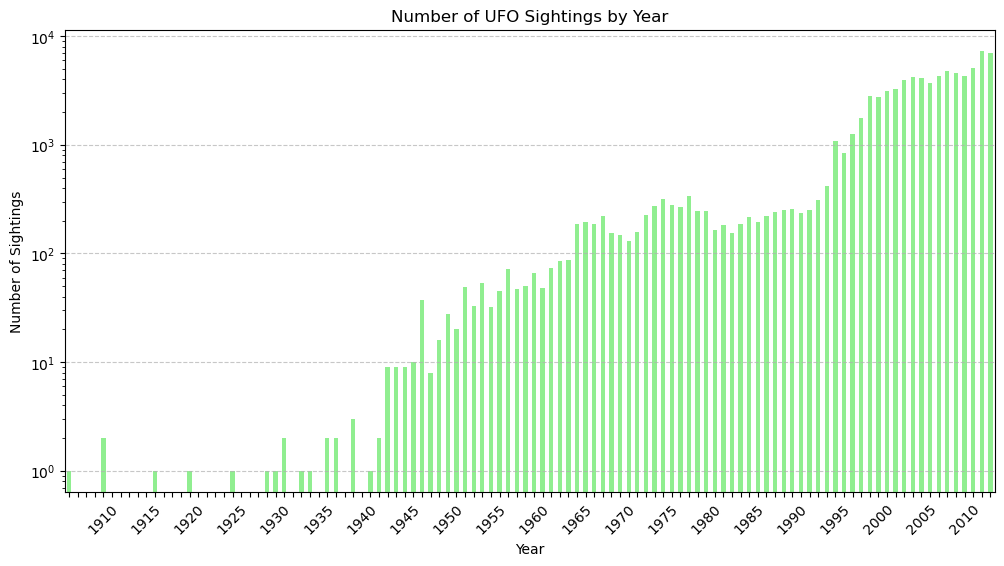

In [70]:
year_count = dataset['datetime'].dt.year.value_counts().sort_index()
all_years = pd.Series(0, index=np.arange(dataset['datetime'].dt.year.min(), dataset['datetime'].dt.year.max()))
year_count = all_years.add(year_count, fill_value=0)
year_count.plot(kind='bar', figsize=(12, 6), color='lightgreen', logy=True)
plt.title('Number of UFO Sightings by Year')
plt.xlabel('Year')
plt.ylabel('Number of Sightings')
plt.grid(axis='y', linestyle='--', alpha=0.7)

years = year_count.index
tick_locs = np.arange(len(years))
tick_labels = [str(year) if year % 5 == 0 else '' for year in years]

plt.xticks(tick_locs, tick_labels, rotation=45)
plt.show()

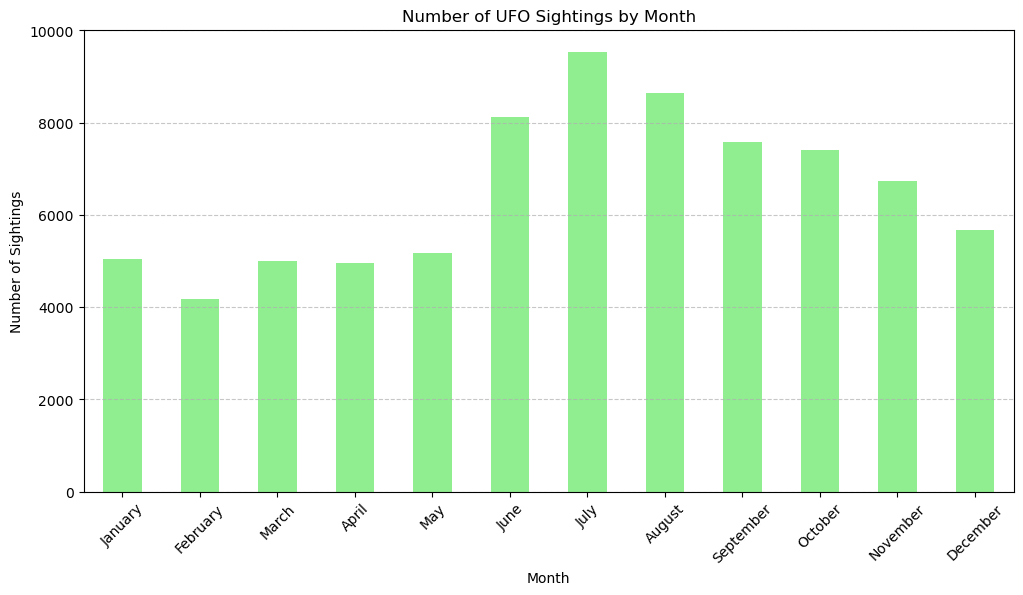

In [71]:
month_count = dataset['datetime'].dt.month.value_counts().sort_index()
month_count.plot(kind='bar', figsize=(12, 6), color='lightgreen')
month_names = ['January', 'February', 'March', 'April', 'May', 'June', 'July', 'August', 'September', 'October', 'November', 'December']
plt.xticks(ticks=np.arange(12), labels=month_names, rotation=45)
plt.title('Number of UFO Sightings by Month')
plt.xlabel('Month')
plt.ylabel('Number of Sightings')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

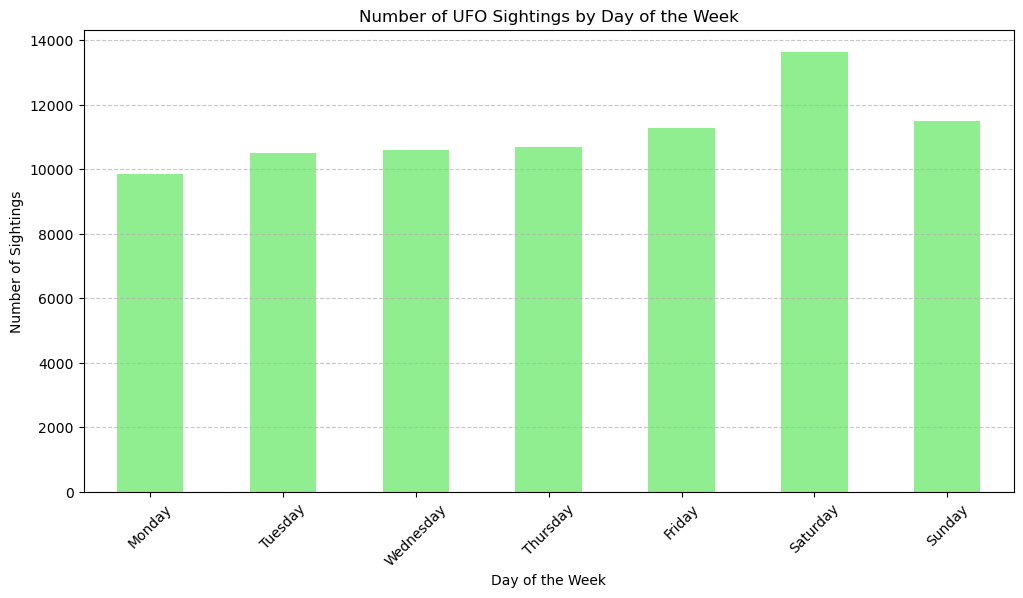

In [72]:
day_of_week_count = dataset['datetime'].dt.dayofweek.value_counts().sort_index()
day_of_week_count.plot(kind='bar', figsize=(12, 6), color='lightgreen')
day_names = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
plt.xticks(ticks=np.arange(7), labels=day_names, rotation=45)
plt.title('Number of UFO Sightings by Day of the Week')
plt.xlabel('Day of the Week')
plt.ylabel('Number of Sightings')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

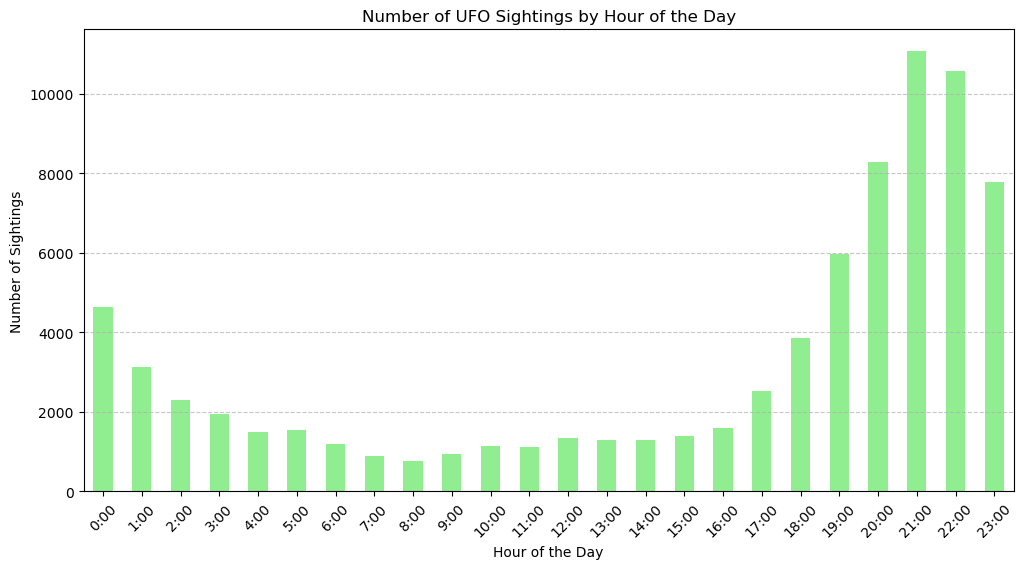

In [73]:
time_of_day_count = dataset['datetime'].dt.hour.value_counts().sort_index()
time_of_day_count.plot(kind='bar', figsize=(12, 6), color='lightgreen')
time_labels = [f'{hour}:00' for hour in range(24)]
plt.xticks(ticks=np.arange(24), labels=time_labels, rotation=45)
plt.title('Number of UFO Sightings by Hour of the Day')
plt.xlabel('Hour of the Day')
plt.ylabel('Number of Sightings')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

shape categories

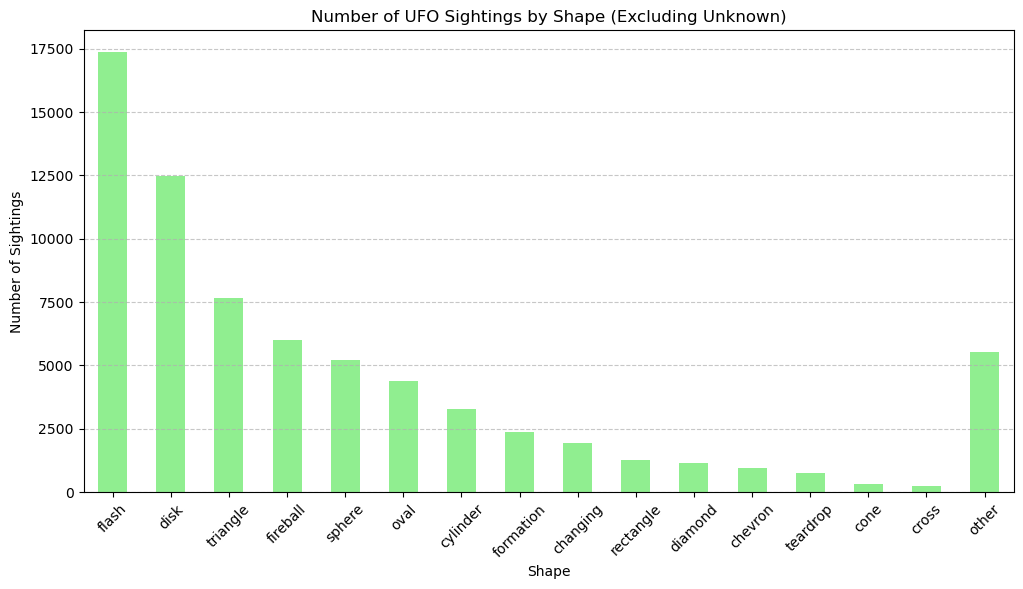

In [78]:
shape_counts = dataset['shape'].value_counts()
shape_counts = shape_counts[shape_counts.index != 'unknown']  # Exclude 'unknown' category
# Move 'other' to the end
shape_counts = shape_counts.reindex(
    [shape for shape in shape_counts.index if shape != 'other'] + ['other']
)
shape_counts.plot(kind='bar', figsize=(12, 6), color='lightgreen')
plt.title('Number of UFO Sightings by Shape (Excluding Unknown)')
plt.xlabel('Shape')
plt.ylabel('Number of Sightings')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.xticks(rotation=45)
plt.show()

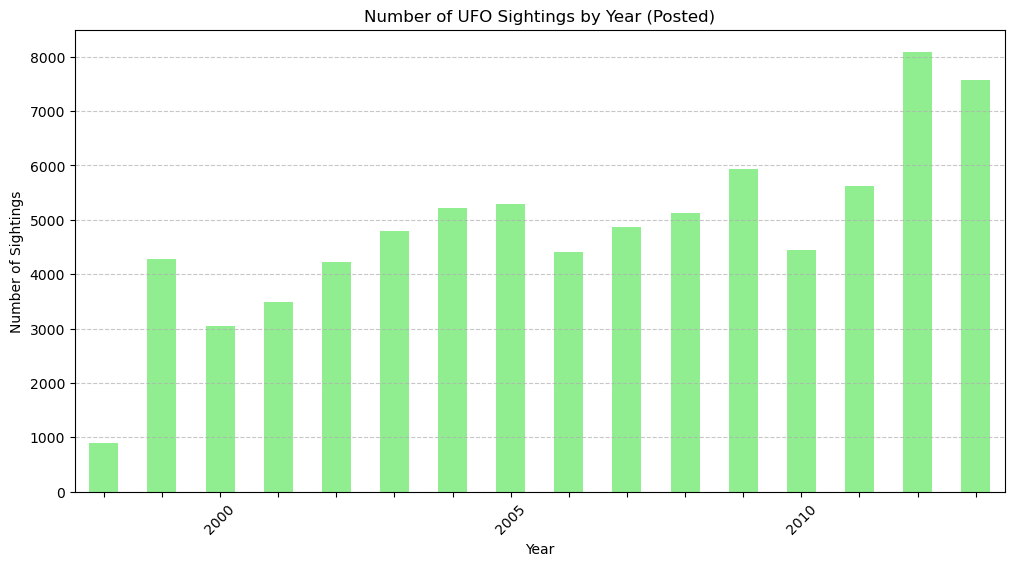

In [96]:
year_count = dataset['date posted'].dt.year.value_counts().sort_index()
all_years = pd.Series(0, index=np.arange(dataset['date posted'].dt.year.min(), dataset['date posted'].dt.year.max()))
year_count = all_years.add(year_count[:-1], fill_value=0)
year_count.plot(kind='bar', figsize=(12, 6), color='lightgreen')
plt.title('Number of UFO Sightings by Year (Posted)')
plt.xlabel('Year')
plt.ylabel('Number of Sightings')
plt.grid(axis='y', linestyle='--', alpha=0.7)

years = year_count.index
tick_locs = np.arange(len(years))
tick_labels = [str(year) if year % 5 == 0 else '' for year in years]

plt.xticks(tick_locs, tick_labels, rotation=45)
plt.show()

sigthing durations

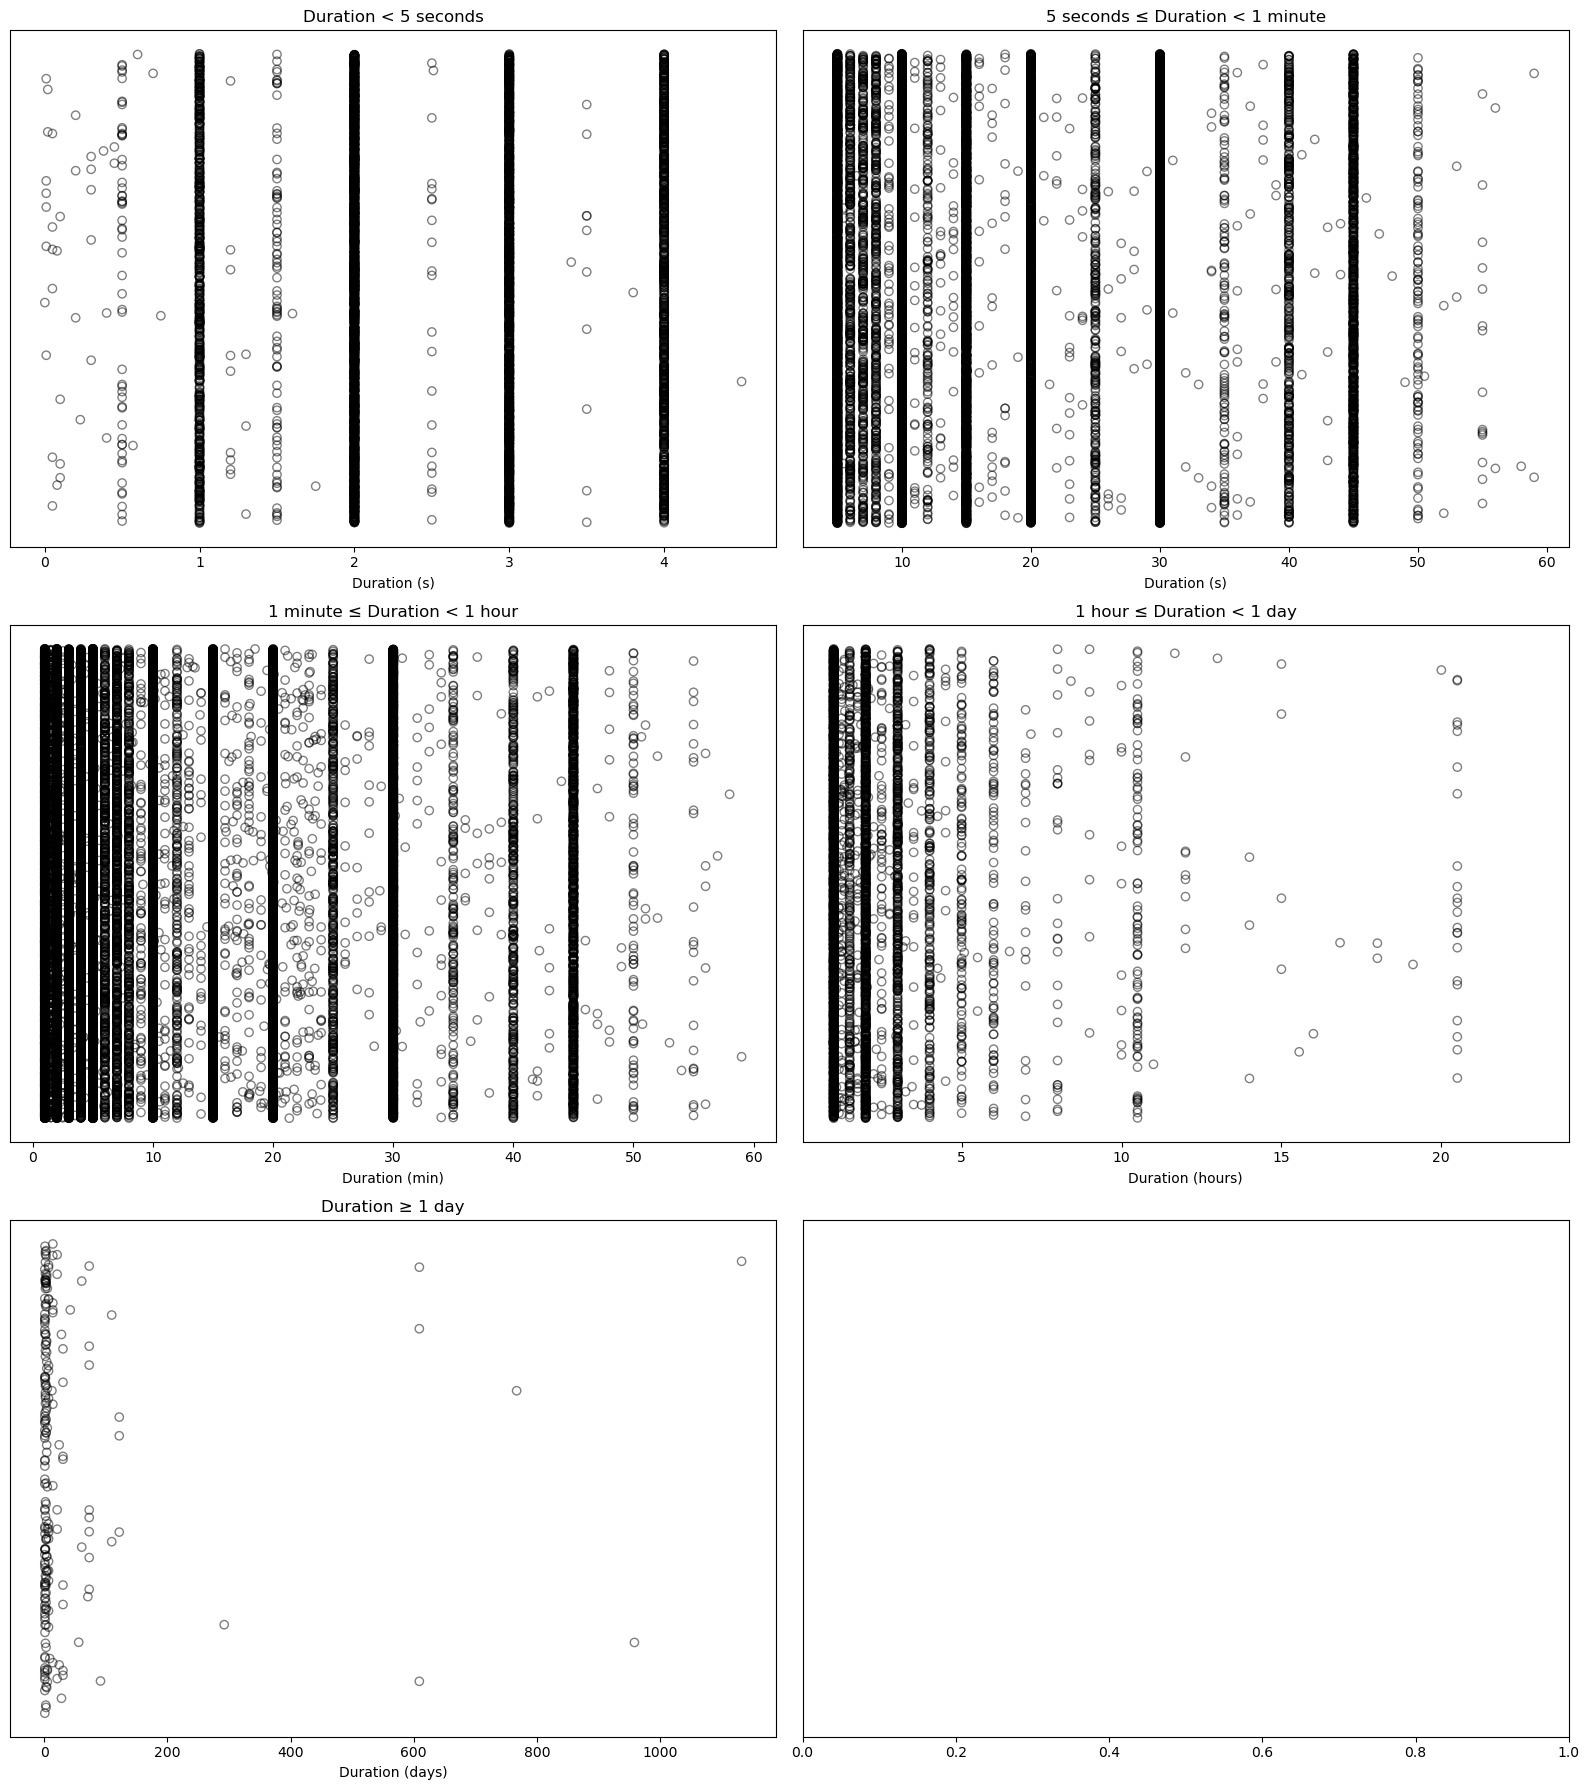

In [95]:
fig, axes = plt.subplots(3, 2, figsize=(16, 18), sharey=True)

# Filter data for each range
less_than_5s = dataset[dataset['duration'] < 5]
between_5s_1m = dataset[(dataset['duration'] >= 5) & (dataset['duration'] < 60)]
between_1m_1h = dataset[(dataset['duration'] >= 60) & (dataset['duration'] < 3600)]
between_1h_1d = dataset[(dataset['duration'] >= 3600) & (dataset['duration'] < 86400)]
greater_than_1d = dataset[dataset['duration'] >= 86400]

# Plot each range
axes[0, 0].scatter(less_than_5s['duration'], [np.random.random() for _ in range(len(less_than_5s))], 
                   alpha=0.5, facecolors='none', edgecolors='black')
axes[0, 0].set_title('Duration < 5 seconds')
axes[0, 0].set_xlabel('Duration (s)')
axes[0, 0].set_yticks([])

axes[0, 1].scatter(between_5s_1m['duration'], [np.random.random() for _ in range(len(between_5s_1m))], 
                   alpha=0.5, facecolors='none', edgecolors='black')
axes[0, 1].set_title('5 seconds ≤ Duration < 1 minute')
axes[0, 1].set_xlabel('Duration (s)')
axes[0, 1].set_yticks([])

axes[1, 0].scatter(between_1m_1h['duration'] / 60, [np.random.random() for _ in range(len(between_1m_1h))], 
                   alpha=0.5, facecolors='none', edgecolors='black')
axes[1, 0].set_title('1 minute ≤ Duration < 1 hour')
axes[1, 0].set_xlabel('Duration (min)')
axes[1, 0].set_yticks([])

axes[1, 1].scatter(between_1h_1d['duration'] / 3600, [np.random.random() for _ in range(len(between_1h_1d))], 
                   alpha=0.5, facecolors='none', edgecolors='black')
axes[1, 1].set_title('1 hour ≤ Duration < 1 day')
axes[1, 1].set_xlabel('Duration (hours)')
axes[1, 1].set_xlim(right=23.99)
axes[1, 1].set_yticks([])

axes[2, 0].scatter(greater_than_1d['duration'] / 86400, [np.random.random() for _ in range(len(greater_than_1d))], 
                   alpha=0.5, facecolors='none', edgecolors='black')
axes[2, 0].set_title('Duration ≥ 1 day')
axes[2, 0].set_xlabel('Duration (days)')
axes[2, 0].set_yticks([])

# Adjust layout
plt.tight_layout()
plt.show()

Correlation between different shapes

/var/folders/kr/bqsygyl90h9gm8qzj278h8c80000gn/T/ipykernel_4432/2277907224.py:17: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  axs[i].scatter(year_data[shape1], year_data[shape2], cmap='coolwarm', edgecolor='k')


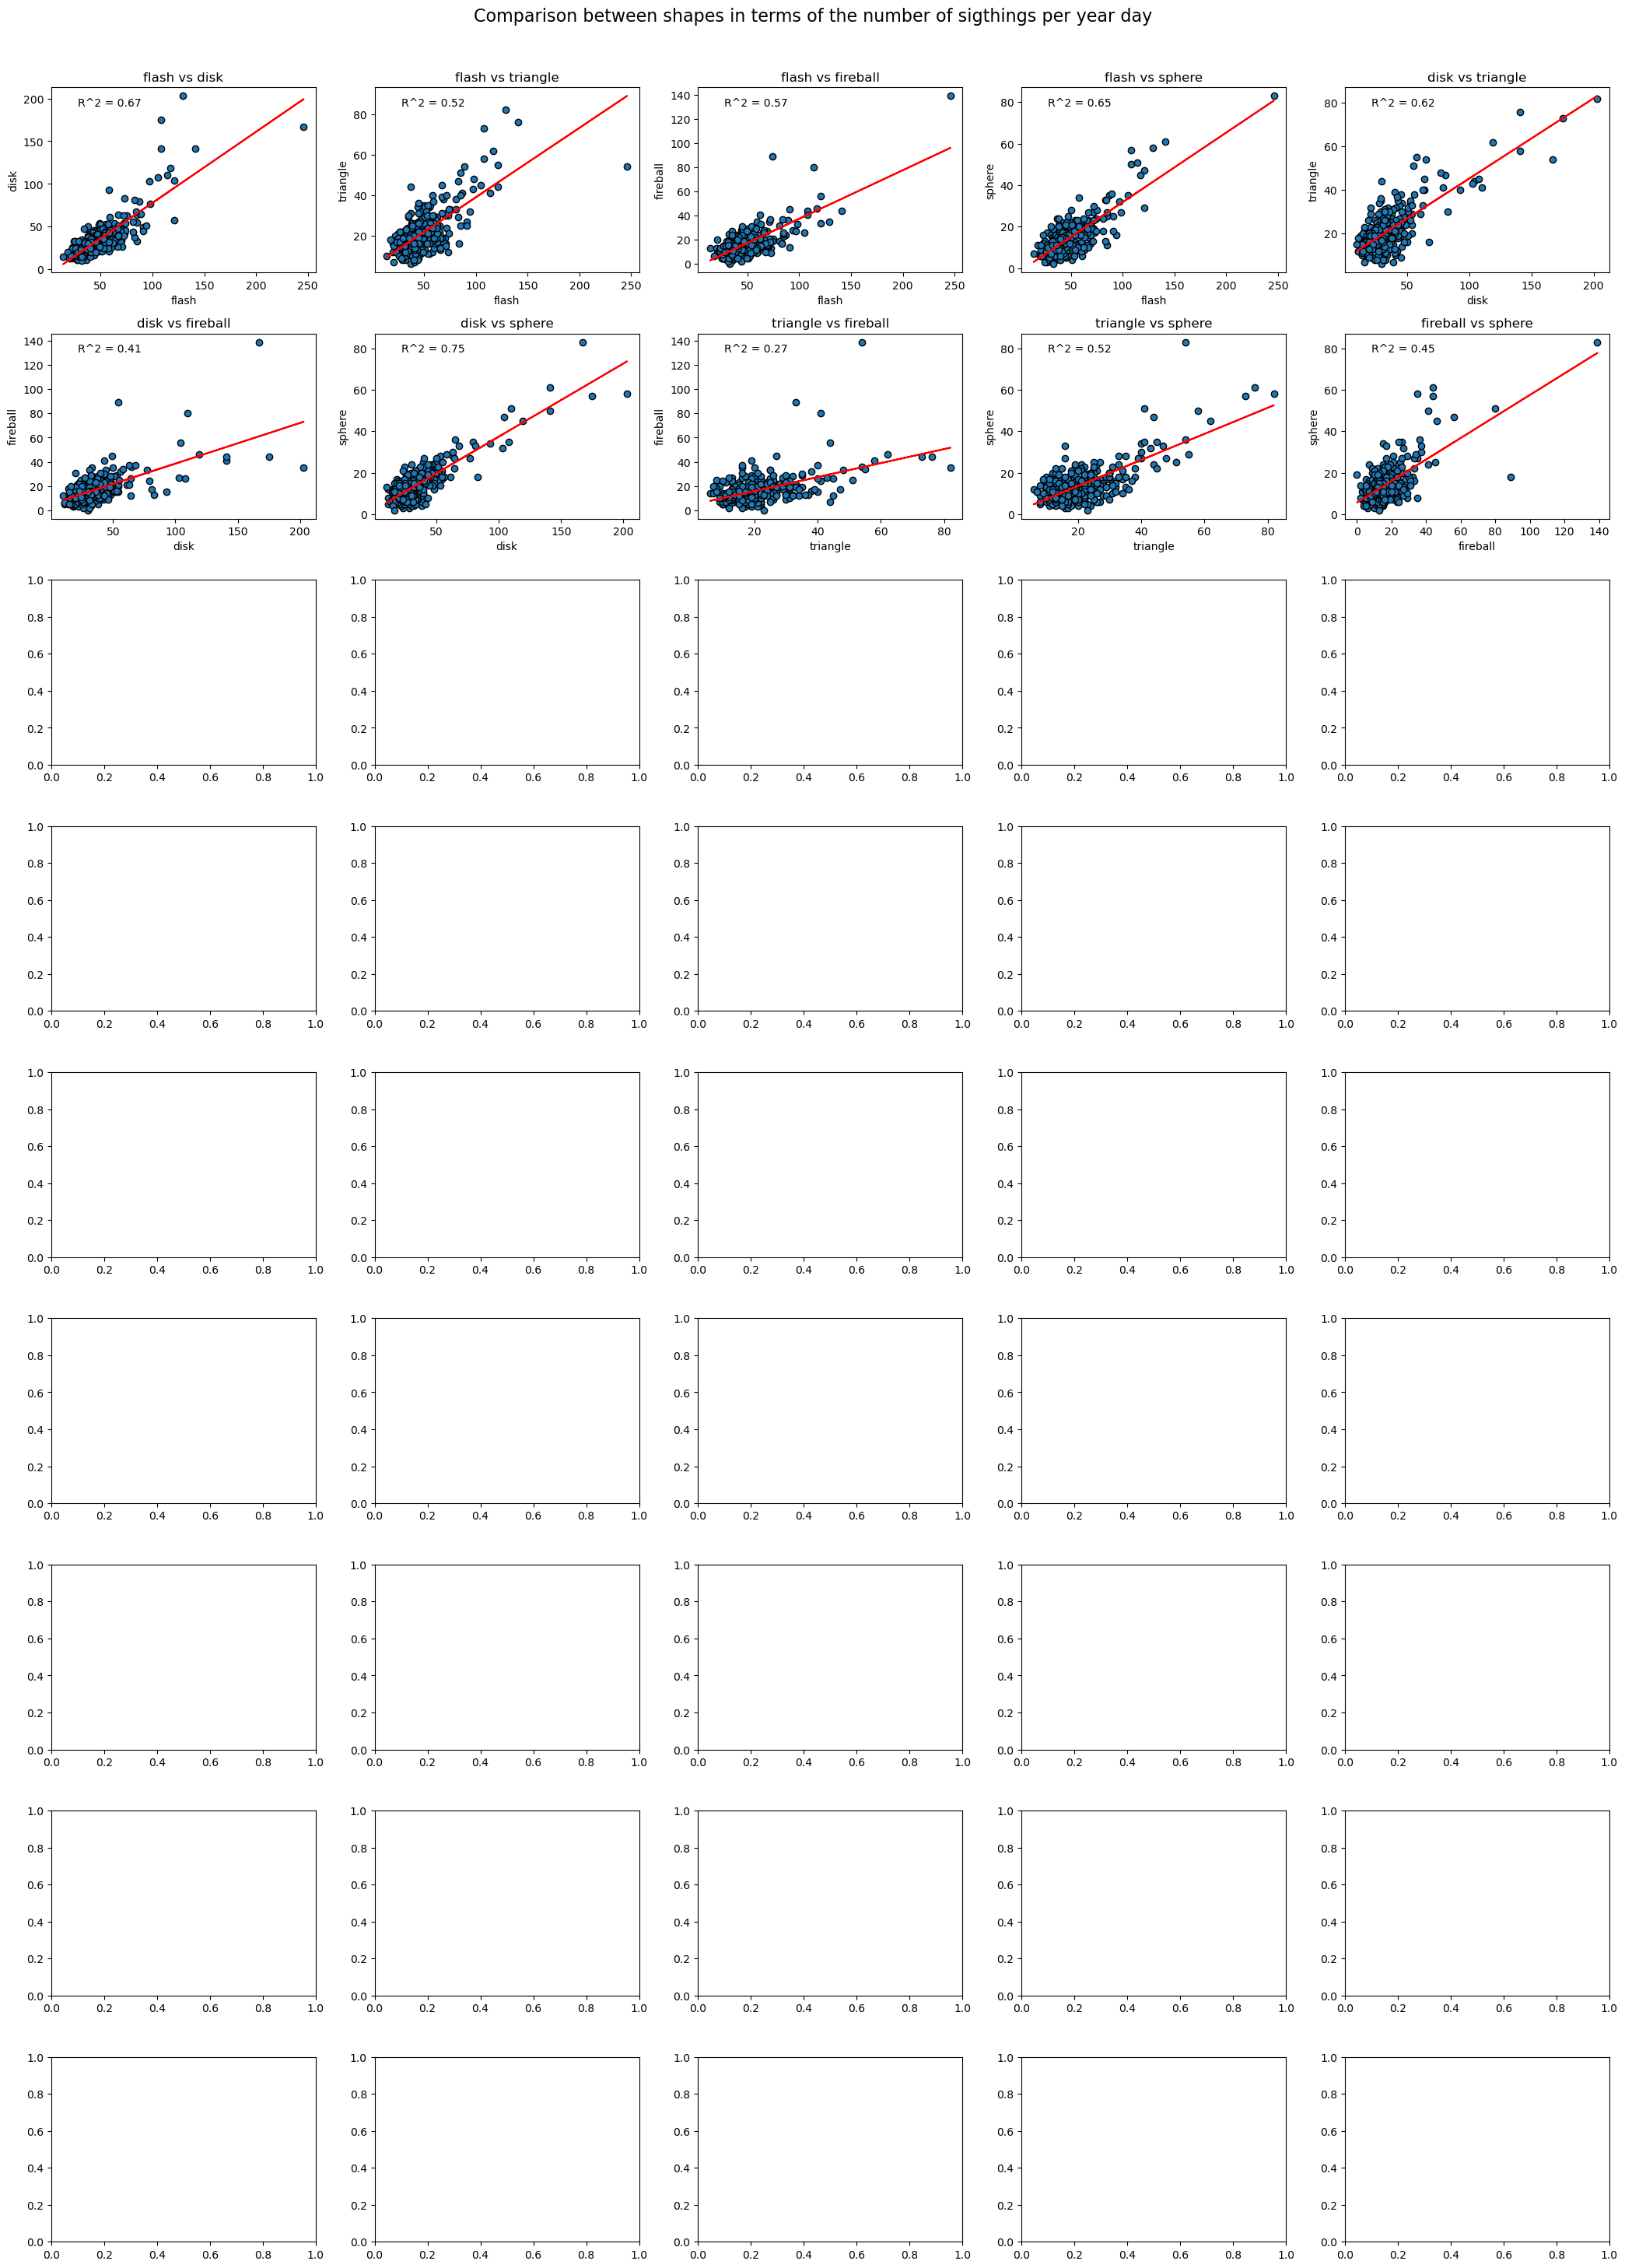

In [ ]:
from itertools import combinations
from scipy.stats import linregress

# Too lazy to do linear regression by hand
focus_cat = ['flash', 'disk', 'triangle', 'fireball', 'sphere'] # categories with more than 5000 sightings
year_data = {}
rvalues = {}
for shape in focus_cat:
    subset_data = dataset[dataset['shape'] == shape]
    year_data[shape] = subset_data['datetime'].dt.day_of_year.value_counts().reindex(range(1, 367), fill_value=0)
fig, axs = plt.subplots(9, 5, figsize=(21, 29.7)) # A4 size
axs = axs.flatten()
for i, (shape1, shape2) in enumerate(combinations(focus_cat, 2)):
    slope, intercept, rvalue, _, _ = linregress(year_data[shape1], year_data[shape2])
    rvalues[(shape1, shape2)] = rvalue**2
    axs[i].plot(year_data[shape1], slope*year_data[shape1] + intercept, color='red')
    axs[i].scatter(year_data[shape1], year_data[shape2], c=year_data[shape1], cmap='coolwarm', edgecolor='k')
    axs[i].set_title(f"{shape1} vs {shape2}")
    axs[i].set_xlabel(shape1)
    axs[i].set_ylabel(shape2)
    axs[i].text(0.1, 0.9, f"R^2 = {rvalue**2:.2f}", transform=axs[i].transAxes)

plt.suptitle("Comparison between shapes in terms of the number of sigthings per year day", fontsize=16)
plt.tight_layout(rect=[0, 0, 1, 0.97])
plt.show()

Correlation between geographical coordinates

In [88]:
print(dataset['datetime'].max())
# Print the entire row of the dataset with the maximum datetime
print(dataset.loc[dataset['duration'] > 864000])

2013-12-31 23:55:00
                 datetime     shape    duration  \
559   1983-10-01 17:00:00    sphere  97836000.0   
693   2001-10-02 00:00:00     other   6312000.0   
3476  2007-10-21 01:00:00     flash   2631600.0   
6991  2013-10-07 20:00:00      disk  10526400.0   
7101  2008-10-08 21:00:00     flash   1209600.0   
8837  2013-11-12 21:30:00    sphere   1209600.0   
10853 1977-01-01 02:30:00   unknown   9468000.0   
14181 2011-11-03 19:21:00   unknown   1209600.0   
14703 1995-01-15 12:00:00   unknown   1209600.0   
17388 2002-12-02 00:00:00  fireball   2631600.0   
20064 2010-12-23 00:00:00  cylinder   2631600.0   
21527 2006-12-31 23:00:00      oval   6312000.0   
21583 2009-12-31 23:30:00   unknown   6312000.0   
21742 2013-12-31 00:00:00      oval   2102400.0   
22584 2004-01-25 19:30:00     other   1814400.0   
23721 1965-12-10 00:00:00  fireball   6120000.0   
24322 2004-01-03 22:30:00   unknown   1814400.0   
24773 2010-01-05 16:00:00  cylinder   1814400.0   
25822 1978-